# Projeto ML

Trabalho de:

* Bárbara Simões Neto up
* Beatriz Castro up
* Rodrigo Couto up202104696


sites usados até então:

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

https://link.springer.com/article/10.1007/s10618-021-00737-9 (so vi as imagens para perceber o que era os diferentes tipos de datasets que o chatzaome deu, elas sao bastantes intuitivas)




In [16]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC  
import matplotlib.pyplot as plt
from sklearn.metrics import zero_one_loss
from mlxtend.evaluate import bias_variance_decomp


In [17]:

#Gerar datasets

def generate_mixed_dataset(n_samples, n_features, n_categorical, n_ordinal, n_integer, 
                           n_classes, class_balance=None, noise=0.0, 
                           dataset_type='linear', random_state=42):

    np.random.seed(random_state)

    if dataset_type == 'linear':
        X, y = make_classification(n_samples=n_samples, n_features=n_features, 
                                  n_informative=n_features, n_redundant=0, 
                                  n_classes=n_classes, weights=class_balance, 
                                  flip_y=noise, random_state=random_state, class_sep=2)
    elif dataset_type == 'moons':
        X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
        if n_features > 2:
            extra_features = np.random.rand(n_samples, n_features - 2) * 100
            X = np.hstack([X, extra_features])
    elif dataset_type == 'circles':
        X, y = make_circles(n_samples=n_samples, noise=noise, random_state=random_state)
        if n_features > 2:
            extra_features = np.random.rand(n_samples, n_features - 2) * 100
            X = np.hstack([X, extra_features])
    elif dataset_type == 'blobs':
        X, y = make_blobs(n_samples=n_samples, centers=n_classes, cluster_std=noise*10, 
                          random_state=random_state)
        if n_features > 2:
            extra_features = np.random.rand(n_samples, n_features - 2) * 100
            X = np.hstack([X, extra_features])
    else:
        raise ValueError("Tipo de dataset não suportado. Use 'linear', 'moons', 'circles' ou 'blobs'.")

    categorical_data = np.random.choice(['A', 'B', 'C', 'D', 'E'], size=(n_samples, n_categorical))

    ordinal_data = np.random.randint(1, 6, size=(n_samples, n_ordinal))  #podem mudar estes valores para criar dataset mais especificos

    integer_data = np.random.randint(0, 100, size=(n_samples, n_integer))  #podem mudar estes valores para criar dataset mais especificos

    # Combina todos os dados em um único array
    data = np.hstack([X, categorical_data, ordinal_data, integer_data])

    columns = [f'Continuous_{i+1}' for i in range(n_features)] + \
              [f'Categorical_{i+1}' for i in range(n_categorical)] + \
              [f'Ordinal_{i+1}' for i in range(n_ordinal)] + \
              [f'Integer_{i+1}' for i in range(n_integer)]
    df = pd.DataFrame(data, columns=columns)

    # Adiciona a coluna target
    df['Target'] = y

    # Converte as colunas para os tipos corretos
    for col in df.columns:
        if col.startswith('Continuous'):
            df[col] = df[col].astype(float)
        elif col.startswith('Ordinal') or col.startswith('Integer'):
            df[col] = df[col].astype(int)

    return df

# SVM linear

Linear SVMs work best with specific types of datasets. They are ideal for linearly separable data, where classes can be clearly divided by a straight line. They also perform well with high-dimensional data, like text or datasets with many features, as they focus on finding a linear decision boundary. Numerical data (continuous or integer values) works best, while categorical data needs to be transformed (e.g., using one-hot encoding). However, linear SVMs have limitations. They struggle with large datasets due to high computational costs and memory usage. They also perform poorly on imbalanced datasets, often favoring the majority class, and on noisy data where classes overlap significantly. For multiclass problems, additional techniques like One-vs-Rest or One-vs-One are needed, as linear SVMs are designed for binary classification. In summary, linear SVMs are best suited for small to medium-sized, high-dimensional, linearly separable datasets with balanced classes and minimal noise.

In [18]:
#gerar dataset adequado

df_svm_linear = generate_mixed_dataset(n_samples=500, n_features=20, n_categorical=0, n_ordinal=0, n_integer=8,
                                                  n_classes=2, class_balance=None, noise=0.1, dataset_type='linear')

print("Best Dataset for Linear SVM:")
print(df_svm_linear.head())


Best Dataset for Linear SVM:
   Continuous_1  Continuous_2  Continuous_3  Continuous_4  Continuous_5  \
0     -2.307608      1.668358      2.252106     -1.968564     -4.929186   
1      4.389963     -0.578385     -2.722650     -2.982947      7.632946   
2     -1.897597      2.994106      0.755542     -5.697095      2.729707   
3      3.867551     -1.917197      2.019131     -0.850470      2.443705   
4     -2.549646      2.202160      2.300397      0.795324     -3.497897   

   Continuous_6  Continuous_7  Continuous_8  Continuous_9  Continuous_10  ...  \
0      0.772611     -5.188637      0.909699      0.951789       1.001922  ...   
1      3.088414     -2.569981      3.337391     -6.984058      -0.624044  ...   
2     -0.131957     -1.698201      0.369110     -0.722678      -1.358863  ...   
3      3.185501     -4.957228     -4.213375     -0.848798       1.247323  ...   
4     -2.680108     -2.706487      5.675596      2.201553      -4.804617  ...   

   Continuous_20  Integer_1  Inte

In [19]:
X1 = df_svm_linear.drop('Target', axis=1)  
y1 = df_svm_linear['Target']  

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

scaler_linear = StandardScaler()
X1_train = scaler_linear.fit_transform(X1_train)
X1_test = scaler_linear.transform(X1_test)

model_linear = LinearSVC(C=0.1, random_state=42)
model_linear.fit(X1_train, y1_train)

y_pred_linear = model_linear.predict(X1_test)

df_svm_linear_2 = generate_mixed_dataset(n_samples=150, n_features=20, n_categorical=0, n_ordinal=0, n_integer=8,
                                       n_classes=2, class_balance=None, noise=0.1, dataset_type='linear')

X_2linear = df_svm_linear_2.drop('Target', axis=1)
y_2linear = df_svm_linear_2['Target']

X_2linear = scaler_linear.transform(X_2linear)

y_pred_2linear = model_linear.predict(X_2linear)

# cv_linear = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores_linear = cross_val_score(model_linear, X_2linear, y_2linear, cv=cv_linear, scoring='accuracy')

# print(f"Linear SVM Cross-Validation Accuracy: {cv_scores_linear.mean():.2f} (± {cv_scores_linear.std():.2f})")
# print("\nLinear SVM Fold Accuracies:")
# for i, score in enumerate(cv_scores_linear, start=1):
#     print(f"Fold {i}: {score:.2f}")

/home/barbara/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


# SVM RBF

The SVM RBF (Radial Basis Function) kernel is ideal for non-linear and complex datasets, as it can capture intricate patterns where classes are not linearly separable. It also handles noisy or overlapping data better than linear SVMs, creating flexible decision boundaries. However, its performance depends heavily on hyperparameter tuning, such as the gamma value. For other aspects, like handling high-dimensional data, numerical features, large datasets, imbalanced classes, and multiclass problems, it behaves similarly to linear SVMs.

In [20]:
#gerar dataset
df_svm_rbf = generate_mixed_dataset(n_samples=500, n_features=20, n_categorical=0,n_ordinal=1,n_integer=8,
    n_classes=2,class_balance=None,noise=0.2,dataset_type='moons', random_state=42)

print("\nMelhor Dataset para SVM RBF:")
print(df_svm_rbf.head())



Melhor Dataset para SVM RBF:
   Continuous_1  Continuous_2  Continuous_3  Continuous_4  Continuous_5  \
0      0.830858     -0.334342     37.454012     95.071431     73.199394   
1      0.991710      0.879000     43.194502     29.122914     61.185289   
2      1.107245     -0.470344     30.461377      9.767211     68.423303   
3     -0.140899      1.033148     59.789998     92.187424      8.849250   
4      0.405592      1.328529      0.552212     81.546143     70.685734   

   Continuous_6  Continuous_7  Continuous_8  Continuous_9  Continuous_10  ...  \
0     59.865848     15.601864     15.599452      5.808361      86.617615  ...   
1     13.949386     29.214465     36.636184     45.606998      78.517596  ...   
2     44.015249     12.203823     49.517691      3.438852      90.932040  ...   
3     19.598286      4.522729     32.533033     38.867729      27.134903  ...   
4     72.900717     77.127035      7.404465     35.846573      11.586906  ...   

   Ordinal_1  Integer_1  Integer

In [21]:
X2 = df_svm_rbf.drop('Target', axis=1)
y2 = df_svm_rbf['Target']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

scaler_rbf = StandardScaler()
X2_train = scaler_rbf.fit_transform(X2_train)
X2_test = scaler_rbf.transform(X2_test)

model_rbf = SVC(C=1.0, kernel='rbf', gamma='scale', random_state=42)
model_rbf.fit(X2_train, y2_train)

y_pred_rbf = model_rbf.predict(X2_test)

df_svm_rbf_2 = generate_mixed_dataset(n_samples=150, n_features=20, n_categorical=0, n_ordinal=1, n_integer=8,
                                    n_classes=2, class_balance=None, noise=0.2, dataset_type='moons')

X_2rbf = df_svm_rbf_2.drop('Target', axis=1)
y_2rbf = df_svm_rbf_2['Target']

X_2rbf = scaler_rbf.transform(X_2rbf)

y_pred_2rbf = model_rbf.predict(X_2rbf)

# cv_rbf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores_rbf = cross_val_score(model_rbf, X_2rbf, y_2rbf, cv=cv_rbf, scoring='accuracy')

# print(f"\nRBF SVM Cross-Validation Accuracy: {cv_scores_rbf.mean():.2f} (± {cv_scores_rbf.std():.2f})")
# print("\nRBF SVM Fold Accuracies:")
# for i, score in enumerate(cv_scores_rbf, start=1):
#     print(f"Fold {i}: {score:.2f}")

## Bias, Variance and Total loss

In [22]:
X1_np = X1_train  
y1_np = y1_train.values if hasattr(y1_train, 'values') else y1_train
X1_np_test = X1_test
y1_np_test = y1_test.values if hasattr(y1_test, 'values') else y1_test


X2_np = X2_train
y2_np = y2_train.values if hasattr(y2_train, 'values') else y2_train
X2_np_test = X2_test
y2_np_test = y2_test.values if hasattr(y2_test, 'values') else y2_test

In [23]:
model_names = ['Linear SVM', 'RBF SVM']
biases = []
variances = []
losses = []

# Calcular para Linear SVM
loss_linear, bias_linear, var_linear = bias_variance_decomp(
        model_linear, X1_np, y1_np, X1_np_test, y1_np_test,
        loss='0-1_loss', random_seed=13
    )
losses.append(loss_linear)
biases.append(bias_linear)
variances.append(var_linear)

# Calcular para RBF SVM
loss_rbf, bias_rbf, var_rbf = bias_variance_decomp(
        model_rbf, X2_np, y2_np, X2_np_test, y2_np_test,
        loss='0-1_loss', random_seed=13
    )
losses.append(loss_rbf)
biases.append(bias_rbf)
variances.append(var_rbf)

/home/barbara/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/barbara/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/barbara/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/barbara/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/barbara/.local/lib/python3

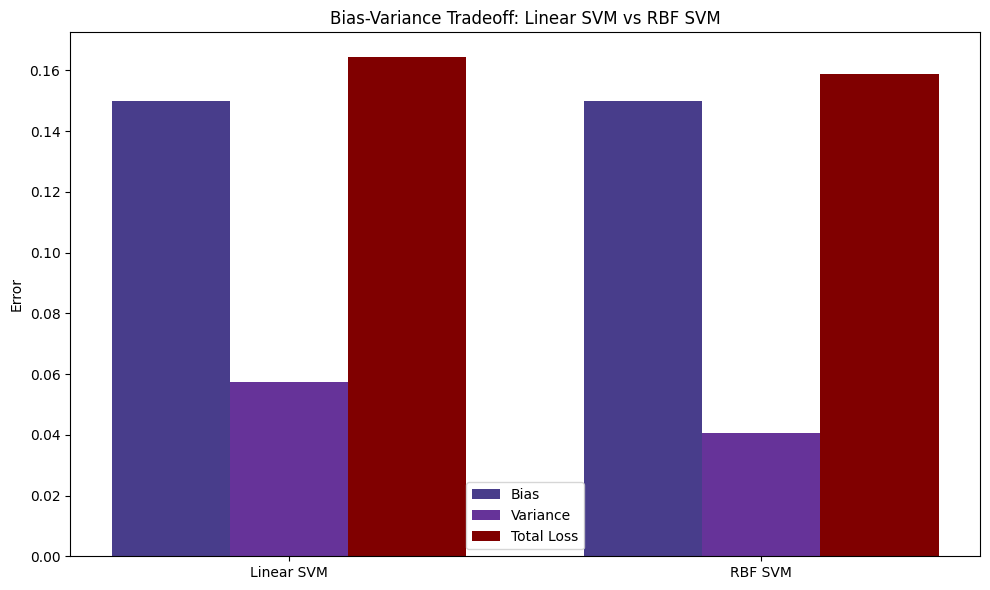

Model Comparison:

Linear SVM:
Bias: 0.1500
Variance: 0.0575
Total Loss: 0.1643

RBF SVM:
Bias: 0.1500
Variance: 0.0405
Total Loss: 0.1589


In [24]:
x = np.arange(len(model_names))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, biases, width, label='Bias', color="darkslateblue")
plt.bar(x, variances, width, label='Variance', color="rebeccapurple")
plt.bar(x + width, losses, width, label='Total Loss', color="maroon")

plt.xticks(x, model_names)
plt.ylabel('Error')
plt.title('Bias-Variance Tradeoff: Linear SVM vs RBF SVM')
plt.legend()
plt.tight_layout()
plt.show()

print("Model Comparison:")
for name, bias, var, loss in zip(model_names, biases, variances, losses):
    print(f"\n{name}:")
    print(f"Bias: {bias:.4f}")
    print(f"Variance: {var:.4f}")
    print(f"Total Loss: {loss:.4f}")

## Cross-Validation

/home/barbara/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/barbara/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/barbara/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/barbara/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/barbara/.local/lib/python3

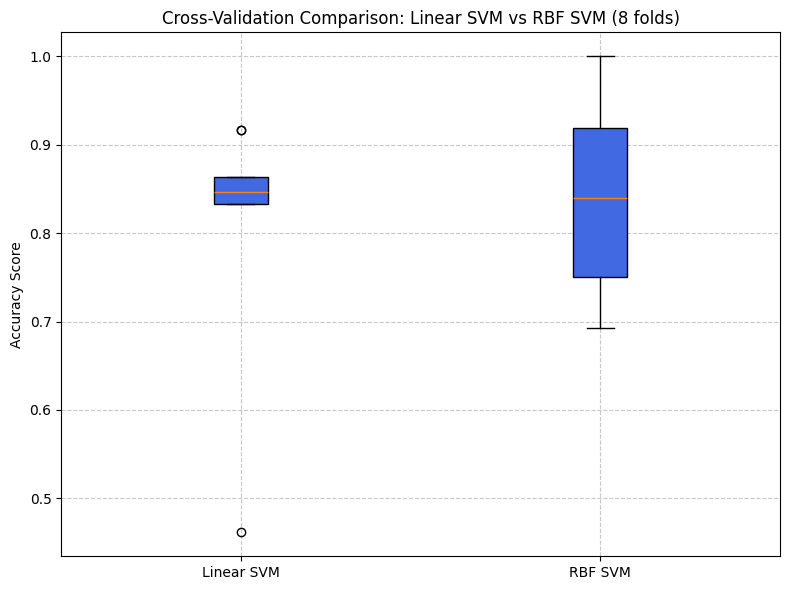

In [25]:
cv_linear = cross_val_score(model_linear, X1_test, y1_test, cv=8)
cv_rbf = cross_val_score(model_rbf, X2_test, y2_test, cv=8)


df_cv_scores_svm = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(8)],
    'Linear SVM': cv_linear,
    'RBF SVM': cv_rbf
})


plt.figure(figsize=(8, 6))
plt.boxplot([cv_linear, cv_rbf], 
            labels=['Linear SVM', 'RBF SVM'], 
            patch_artist=True,
            boxprops=dict(facecolor='royalblue'))
plt.ylabel('Accuracy Score')
plt.title('Cross-Validation Comparison: Linear SVM vs RBF SVM (8 folds)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
